# 4-3 Lane Filter and Car Commands
###      4-3-1 Line Detection
###      4-3-2 Lane Filter
###      4-3-3 Car Commands

## 4-3-1 Line Detection
### Import Packages and Load the image and resize

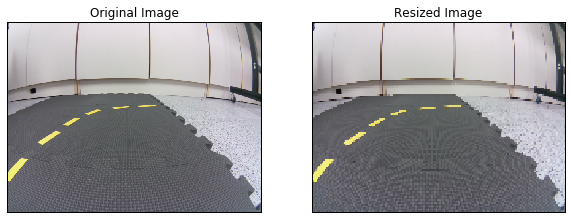

In [77]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

#Use your own image
img = cv2.imread("images/curve-right.jpg")

image_cv = cv2.resize(img, (160, 120),interpolation=cv2.INTER_NEAREST)

dst1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.subplot(121),plt.imshow(dst1,cmap = 'brg')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

dst2 = cv2.cvtColor(image_cv,cv2.COLOR_BGR2RGB)
plt.subplot(122),plt.imshow(dst2,cmap = 'brg')
plt.title('Resized Image'), plt.xticks([]), plt.yticks([])

plt.show()


### Find the Edges

You should find the config file 'universal.yaml'

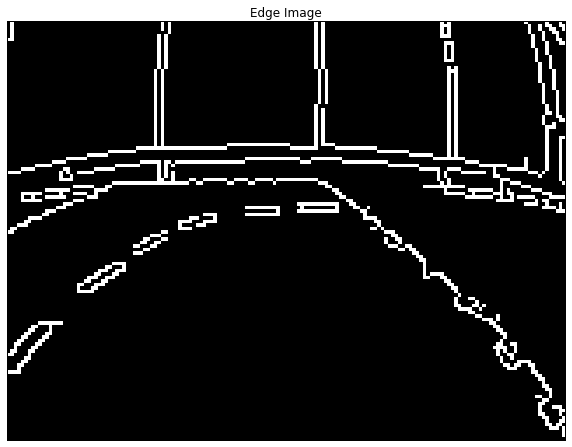

In [78]:
gray = cv2.cvtColor(image_cv,cv2.COLOR_BGR2GRAY)
edges=cv2.Canny(gray,100,350)
plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

### Setup HSV Space Threshold

You should find the config file 'universal.yaml'

In [79]:
hsv_white1 = np.array([0,0,150])
hsv_white2 = np.array([180,100,255])
hsv_yellow1 = np.array([25,50,50])
hsv_yellow2 = np.array([45,255,255])
hsv_red1 = np.array([0,100,100])
hsv_red2 = np.array([15,255,255])
hsv_red3 = np.array([165,100,100])
hsv_red4 = np.array([180,255,255])

### Threshold colors in HSV space

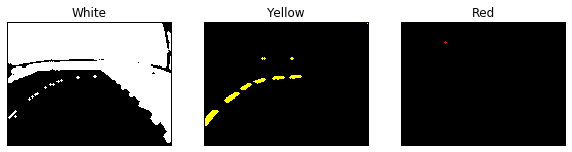

In [80]:
hsv = cv2.cvtColor(image_cv,cv2.COLOR_BGR2HSV)
white = cv2.inRange(hsv,hsv_white1,hsv_white2)
yellow = cv2.inRange(hsv,hsv_yellow1,hsv_yellow2)
red1 = cv2.inRange(hsv,hsv_red1,hsv_red2)
red2 = cv2.inRange(hsv,hsv_red3,hsv_red4)
red = cv2.bitwise_or(red1,red2)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3, 3))
white = cv2.dilate(white, kernel)
yellow = cv2.dilate(yellow, kernel)
red = cv2.dilate(red, kernel)
# Uncomment '#' to plot with color
x = cv2.cvtColor(yellow, cv2.COLOR_GRAY2BGR)
x[:,:,2] *= 1
x[:,:,1] *= 1
x[:,:,0] *= 0
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

y = cv2.cvtColor(red, cv2.COLOR_GRAY2BGR)
y[:,:,2] *= 1
y[:,:,1] *= 0
y[:,:,0] *= 0
y = cv2.cvtColor(y, cv2.COLOR_BGR2RGB)

plt.subplot(131),plt.imshow(white,cmap = 'gray')
plt.title('White'), plt.xticks([]), plt.yticks([])

plt.subplot(132),plt.imshow(yellow,cmap = 'gray')
plt.subplot(132),plt.imshow(x,cmap = 'brg')
plt.title('Yellow'), plt.xticks([]), plt.yticks([])

plt.subplot(133),plt.imshow(red,cmap = 'gray')
plt.subplot(133),plt.imshow(y,cmap = 'brg')
plt.title('Red'), plt.xticks([]), plt.yticks([])

plt.show()

### Combine Edge and Colors

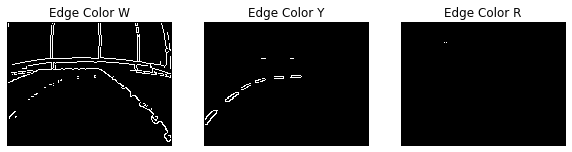

In [81]:
edge_color_white=cv2.bitwise_and(edges,white)
edge_color_yellow=cv2.bitwise_and(edges,yellow)
edge_color_red=cv2.bitwise_and(edges,red)

plt.imshow(edge_color_yellow,cmap = 'gray')
plt.title('Edge Color Y'), plt.xticks([]), plt.yticks([])
plt.subplot(131),plt.imshow(edge_color_white,cmap = 'gray')
plt.title('Edge Color W'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(edge_color_yellow,cmap = 'gray')
plt.title('Edge Color Y'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(edge_color_red,cmap = 'gray')
plt.title('Edge Color R'), plt.xticks([]), plt.yticks([])

plt.show()

### Find the lines

In [82]:
lines_white = cv2.HoughLinesP(edge_color_white,1,np.pi/180,10,np.empty(1),1.5,1)
lines_yellow = cv2.HoughLinesP(edge_color_yellow,1,np.pi/180,10,np.empty(1),1.5,1)
lines_red = cv2.HoughLinesP(edge_color_red,1,np.pi/180,10,np.empty(1),1.5,1)

color = "yellow"
lines = lines_yellow
bw = yellow

if lines is not None:
    lines = np.array(lines[0])
    print "found lines"

else:
    lines = []
    print "no lines"

found lines


### Show the lines (yellow)

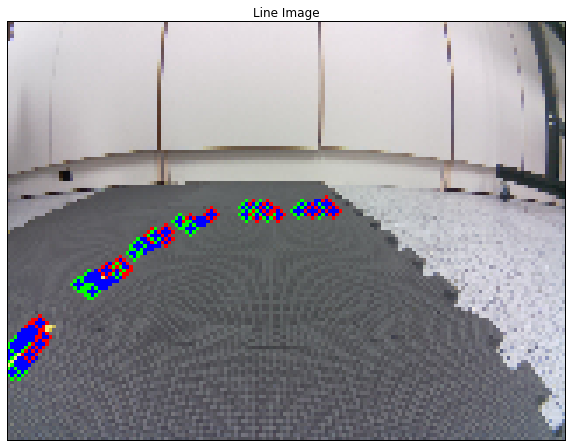

In [83]:
image_with_lines = np.copy(dst2)
if len(lines)>0:
    for x1,y1,x2,y2 in lines:
        cv2.line(image_with_lines, (x1,y1), (x2,y2), (0,0,255), 2)
        cv2.circle(image_with_lines, (x1,y1), 2, (0,255,0))
        cv2.circle(image_with_lines, (x2,y2), 2, (255,0,0))
        
plt.imshow(image_with_lines,cmap = 'brg')
plt.title('Line Image'), plt.xticks([]), plt.yticks([])
plt.show()

### Find normals

In [84]:
arr_cutoff = np.array((0, 40, 0, 40))
arr_ratio = np.array((1./160, 1./120, 1./160, 1./120))
        
normals = []
centers = []
if len(lines)>0:
    
    #find the normalized coordinates
    lines_normalized = ((lines + arr_cutoff) * arr_ratio)
    length = np.sum((lines[:,0:2]-lines[:,2:4])**2,axis=1,keepdims=True)**0.5
    dx = 1.*(lines[:,3:4]-lines[:,1:2])/length
    dy = 1.*(lines[:,0:1]-lines[:,2:3])/length
    centers = np.hstack([(lines[:,0:1]+lines[:,2:3])/2,(lines[:,1:2]+lines[:,3:4])/2])
    #find the vectors' direction
    x3 = (centers[:,0:1] - 3.*dx).astype('int')
    x3[x3<0]=0
    x3[x3>=160]=160-1

    y3 = (centers[:,1:2] - 3.*dy).astype('int')
    y3[y3<0]=0
    y3[y3>=120]=120-1

    x4 = (centers[:,0:1] + 3.*dx).astype('int')
    x4[x4<0]=0
    x4[x4>=160]=160-1
    
    y4 = (centers[:,1:2] + 3.*dy).astype('int')
    y4[y4<0]=0
    y4[y4>=120]=120-1
    
    flag_signs = (np.logical_and(bw[y3,x3]>0,bw[y4,x4]==0)).astype('int')*2-1
    normals = np.hstack([dx, dy]) * flag_signs
    flag = ((lines[:,2]-lines[:,0])*normals[:,1] - (lines[:,3]-lines[:,1])*normals[:,0])>0
    for i in range(len(lines)):
        if flag[i]:
            x1,y1,x2,y2 = lines[i, :]
            lines[i, :] = [x2,y2,x1,y1]

### Draw the normals 

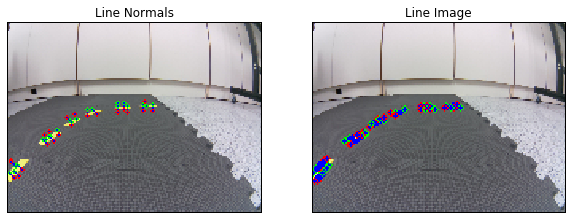

In [85]:
image_with_lines = np.copy(dst2)
if len(centers)>0:
    for x,y,dx,dy in np.hstack((centers,normals)):
        x3 = int(x - 2.*dx)
        y3 = int(y - 2.*dy)
        x4 = int(x + 2.*dx)
        y4 = int(y + 2.*dy)
        cv2.line(image_with_lines, (x3,y3), (x4,y4), (0,0,255), 1)
        cv2.circle(image_with_lines, (x3,y3), 1, (0,255,0))
        cv2.circle(image_with_lines, (x4,y4), 1, (255,0,0))
            
plt.subplot(121),plt.imshow(image_with_lines,cmap = 'brg')
plt.title('Line Normals'), plt.xticks([]), plt.yticks([])

image_with_lines = np.copy(dst2)
if len(lines)>0:
    for x1,y1,x2,y2 in lines:
        cv2.line(image_with_lines, (x1,y1), (x2,y2), (0,0,255), 2)
        cv2.circle(image_with_lines, (x1,y1), 2, (0,255,0))
        cv2.circle(image_with_lines, (x2,y2), 2, (255,0,0))
        
plt.subplot(122),plt.imshow(image_with_lines,cmap = 'brg')
plt.title('Line Image'), plt.xticks([]), plt.yticks([])
plt.show()

## 4-3-2 Lane Filter

### Import packages

In [86]:
import numpy as np
from scipy.stats import multivariate_normal, entropy
from scipy.ndimage.filters import gaussian_filter
from math import floor, atan2, pi, cos, sin, sqrt
import time
from matplotlib import pyplot as plt

### Environment Setup

In [87]:
# constant
WHITE = 0
YELLOW = 1
RED = 2

lanewidth = 0.4
linewidth_white = 0.04
linewidth_yellow = 0.02


### Generate Vote from Line Segments

#### Setup a line segment
* left edge of white lane
* right edge of white lane
* left edge of yellow lane
* right edge of white lane

In [88]:

# right edge of white lane
#p1 = np.array([0.8, 0.24])
#p2 = np.array([0.4, 0.24])
p1 = np.array([lines_normalized[0][0],lines_normalized[0][1]])
p2 = np.array([lines_normalized[0][2],lines_normalized[0][3]]) 
seg_color = YELLOW

# left edge of white lane
#p1 = np.array([0.4, 0.2])
#p2 = np.array([0.8, 0.2])
#seg_color = WHITE

#plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'ro')
#plt.plot([p1[0], p2[0]], [p1[1], p2[1]])
#plt.ylabel('y')
#plt.axis([0, 5, 0, 5])
#plt.show()

#### compute d_i, phi_i, l_i

In [89]:
t_hat = (p2-p1)/np.linalg.norm(p2-p1)
n_hat = np.array([-t_hat[1],t_hat[0]])
d1 = np.inner(n_hat,p1)
d2 = np.inner(n_hat,p2)
l1 = np.inner(t_hat,p1)
l2 = np.inner(t_hat,p2)

print (d1, d2, l1, l2)

if (l1 < 0):
    l1 = -l1;
if (l2 < 0):
    l2 = -l2;
l_i = (l1+l2)/2
d_i = (d1+d2)/2
phi_i = np.arcsin(t_hat[1])
if seg_color == WHITE: # right lane is white
    if(p1[0] > p2[0]): # right edge of white lane
        d_i = d_i - linewidth_white
        print ('right edge of white lane')
    else: # left edge of white lane
        d_i = - d_i
        phi_i = -phi_i
        print ('left edge of white lane')
    d_i = d_i - lanewidth/2

elif seg_color == YELLOW: # left lane is yellow
    if (p2[0] > p1[0]): # left edge of yellow lane
        d_i = d_i - linewidth_yellow
        phi_i = -phi_i
        print ('right edge of yellow lane')
    else: # right edge of white lane
        d_i = -d_i
        print ('right edge of yellow lane')
    d_i =  lanewidth/2 - d_i

    
print (d_i, phi_i, l_i) 

(0.87462972586141063, 0.87462972586141063, -0.25675984969884147, -0.19137503792186139)
right edge of yellow lane
(-0.65462972586141066, 0.53495507378609641, 0.22406744381035143)


### Measurement Likelihood

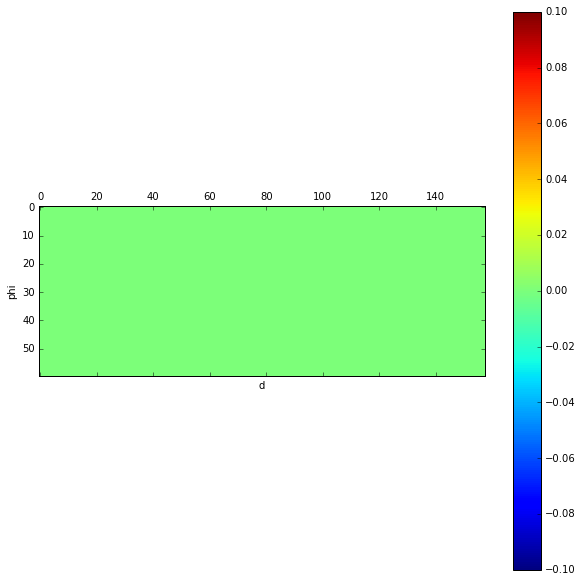

In [90]:
# initialize measurement likelihood

d_min = -0.7
d_max = 0.5
delta_d = 0.02
phi_min = -pi/2
phi_max = pi/2
delta_phi = 0.02
d, phi = np.mgrid[d_min:d_max:delta_d, phi_min:phi_max:delta_phi]

measurement_likelihood = np.zeros(d.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(measurement_likelihood, interpolation='nearest')
fig.colorbar(cax)
plt.ylabel('phi')
plt.xlabel('d')
#ax.set_xticklabels(['']+alpha)
#ax.set_yticklabels(['']+alpha)
plt.show()



/home/robotvision/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


(2.0, 105.0)


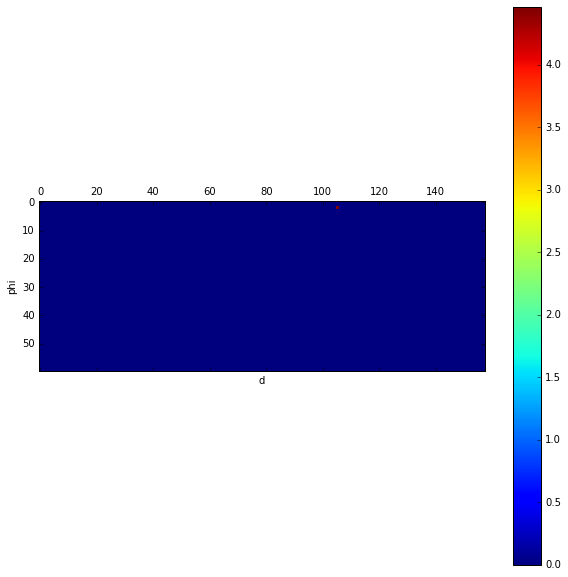

In [91]:
i = floor((d_i - d_min)/delta_d)
j = floor((phi_i - phi_min)/delta_phi)
measurement_likelihood[i,j] = measurement_likelihood[i,j] +  1/(l_i)

print (i, j)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(measurement_likelihood, interpolation='nearest')
fig.colorbar(cax)
plt.ylabel('phi')
plt.xlabel('d')
#ax.set_xticklabels(['']+alpha)
#ax.set_yticklabels(['']+alpha)
plt.show()

## 4-3-3 Car Command

### Import Packages

In [92]:
import numpy as np
import scipy as sp
import cv2
import time

from matplotlib import pyplot as plt
%matplotlib inline
# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels

### ROS Setup

In [93]:
import sys
# rospy
sys.path.insert(0, '/opt/ros/indigo/lib/python2.7/dist-packages')
# rospkg
sys.path.insert(0, '/usr/lib/python2.7/dist-packages/')

# duckietown_msgs
duckietown_root = '../../'  # this file should be run from {duckietown_root}/turorials/python (otherwise change this line)
sys.path.insert(0, duckietown_root + 'catkin_ws/devel/lib/python2.7/dist-packages')

import rospy
from duckietown_msgs.msg import  Twist2DStamped


### Take a look at the ROS Topics

In [94]:
%%bash
rostopic list

ERROR: Unable to communicate with master!


### Initial a ROS Node
* modified "car13" to your duckiebot's name

In [95]:
rospy.init_node("joystick_jupyter",anonymous=False)
#please replace "car13" with your duckiebot name
pub_car_cmd = rospy.Publisher("/car13/joystick_jupyter/car_cmd",Twist2DStamped,queue_size=1)


### Define a function for publishing car command 

In [96]:
def car_command(v, omega, duration):
# Send stop command
    car_control_msg = Twist2DStamped()
    car_control_msg.v = v 
    car_control_msg.omega = omega 
    pub_car_cmd.publish(car_control_msg)
    rospy.sleep(duration)
    #rospy.loginfo("Shutdown")
    car_control_msg.v = 0.0 
    car_control_msg.omega = 0.0 
    pub_car_cmd.publish(car_control_msg)   

### Forward (F), Turn Left (L), or Turn Right (R)

Send commands and calibrate your duckiebot

### Ex1: Forward 0.5 Tile Width

In [97]:
car_command(0.5, 0, 0.75)

### EX2: Turn 45 or 90 Degrees

In [74]:
car_command(0.2, 4, 1.005)

### Setup a Switch for concat of primitives

In [75]:
class switch(object):
    def __init__(self, value):
        self.value = value
        self.fall = False
 
    def __iter__(self):
        """Return the match method once, then stop"""
        yield self.match
        raise StopIteration
     
    def match(self, *args):
        """Indicate whether or not to enter a case suite"""
        if self.fall or not args:
            return True
        elif self.value in args: # changed for v1.5, see below
            self.fall = True
            return True
        else:
            return False

def motion_concat(concat):
    for i in range(len(concat)):
        primitives = concat[i]
        for case in switch(primitives):
            if case('S'):
                car_command(0.5, 0, 0.25)
                break
            if case('L'):
                car_command(0.2, 4, 0.82)
                break
            if case('R'):
                car_command(0.2, -4, 0.78)
                break
            if case('B'):
                car_command(-0.4, 0, 0.5)
                break

### Ex3: Overtaking

In [76]:
overtaking = "LSRSSSSRSLSS"
motion_concat(overtaking)